In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import BSpline
from scipy.optimize import minimize

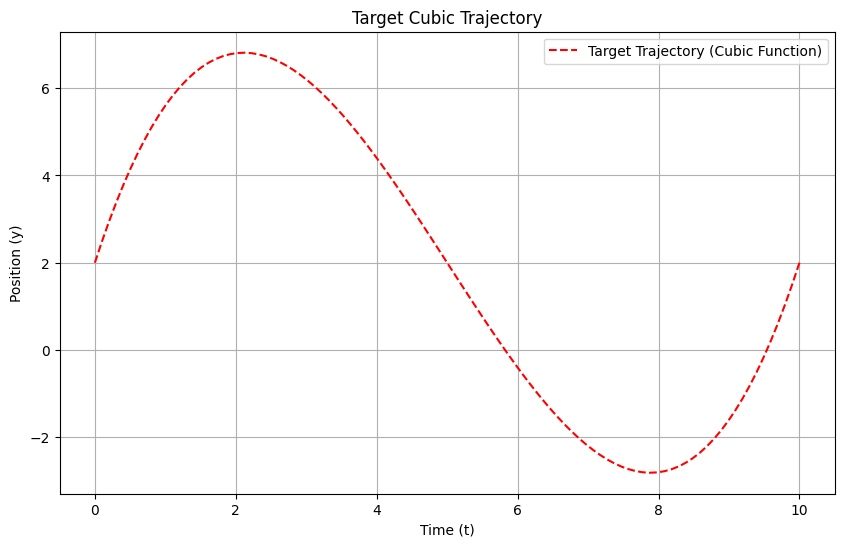

In [2]:
# --- 第零步：定义时间到相位的映射函数 ---
def time_to_phase(t, t_start, t_end):
    """将时间t从 [t_start, t_end] 映射到相位phi [0, 1]。"""
    if t_end == t_start: # 避免除以零
        return 0.0
    return (t - t_start) / (t_end - t_start)

def phase_to_time(phi, t_start, t_end):
    """将相位phi从 [0, 1] 映射到时间t [t_start, t_end]。"""
    return t_start + phi * (t_end - t_start)

# --- 第一步：定义目标轨迹 (现在可以接受相位作为输入，或者在调用时转换) ---
def target_trajectory_t(t):

    return 0.1 * t**3 - 1.5 * t**2 + 5 * t + 2

# 定义时间范围
t_start = 0
t_end = 10
num_points = 100 # 用于绘制的采样点数量
t_values = np.linspace(t_start, t_end, num_points)
y_target = target_trajectory_t(t_values)

# 将时间值映射到相位值
phi_values = time_to_phase(t_values, t_start, t_end)
# 注意：如果目标轨迹本身就是关于相位的，那就不用转换了。这里保持对时间的依赖，但我们用相位来驱动B样条。

# 可视化目标轨迹 
plt.figure(figsize=(10, 6))
plt.plot(t_values, y_target, label='Target Trajectory (Cubic Function)', color='red', linestyle='--')
plt.title('Target Cubic Trajectory')
plt.xlabel('Time (t)')
plt.ylabel('Position (y)')
plt.grid(True)
plt.legend()
plt.show()

In [3]:
# --- 第二步：设置B样条的参数 (现在节点在 [0, 1] 范围内) ---
p = 3  # 阶数 (degree) - 三次B样条
num_control_points = 7 # 控制点数量 (n+1)

# 计算节点数量
num_knots = num_control_points + p + 1

# 生成节点向量 (Uniform knots with repeated end points)
# 现在节点在 [0, 1] 范围内
knots = np.zeros(num_knots)
knots[:p+1] = 0.0 # 前 p+1 个节点为 0.0
knots[num_knots - (p+1):] = 1.0 # 后 p+1 个节点为 1.0

# 填充中间的节点
# 确保中间节点均匀分布在 (0, 1) 之间
knots[p+1 : num_knots - (p+1)] = np.linspace(
    0.0,
    1.0,
    num_knots - 2*(p+1) + 2 # 内部节点数 + 2个端点 (它们会重复)
)[1:-1] # 掐头去尾，只取中间部分

# 打印节点向量
print(f"B-spline degree (p): {p}")
print(f"Number of control points (n+1): {num_control_points}")
print(f"Number of knots (m+1): {num_knots}")
print(f"Knot vector (in phase [0,1]): {knots}")

B-spline degree (p): 3
Number of control points (n+1): 7
Number of knots (m+1): 11
Knot vector (in phase [0,1]): [0.   0.   0.   0.   0.25 0.5  0.75 1.   1.   1.   1.  ]


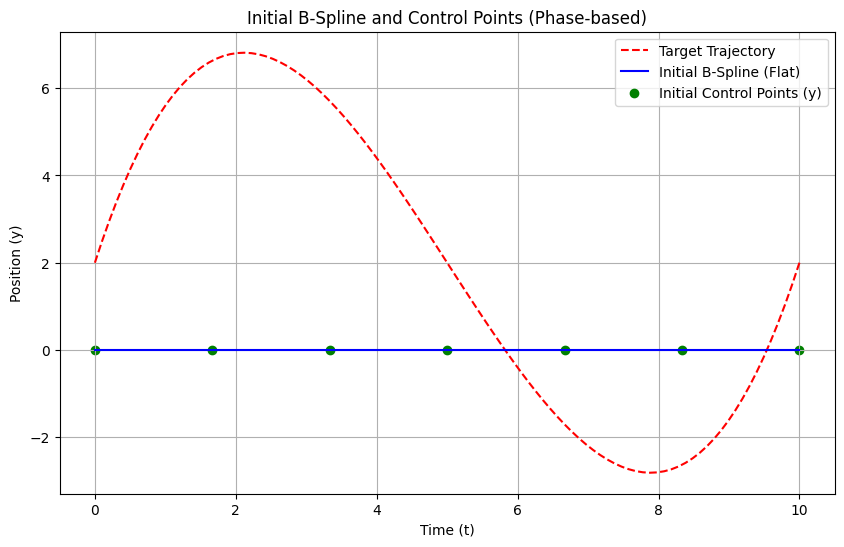

In [15]:
# 初始化控制点 (y坐标)
# 它们的x坐标是隐式的，根据B样条的参数化在 [0, 1] 相位空间中等距分布
control_points_y_initial = np.zeros(num_control_points)

# 创建一个初始的B样条对象
initial_tck = (knots, control_points_y_initial, p)
initial_spline_y = BSpline(*initial_tck)

# 绘制初始的B样条曲线
# 注意：评估B样条时传入的是相位值 phi_values
plt.figure(figsize=(10, 6))
plt.plot(t_values, y_target, label='Target Trajectory', color='red', linestyle='--')
plt.plot(t_values, initial_spline_y(phi_values), label='Initial B-Spline (Flat)', color='blue') # <-- 评估时传入phi_values
# 控制点 x 坐标现在在 [0, 1] 相位，绘制时需映射回时间 t
control_points_phi_x = np.linspace(0.0, 1.0, num_control_points)
control_points_t_x = phase_to_time(control_points_phi_x, t_start, t_end)
plt.scatter(control_points_t_x, control_points_y_initial, color='green', marker='o', label='Initial Control Points (y)')
plt.title('Initial B-Spline and Control Points (Phase-based)')
plt.xlabel('Time (t)')
plt.ylabel('Position (y)')
plt.grid(True)
plt.legend()
plt.show()

In [12]:
# --- 第三步：通过优化拟合目标轨迹 ---

# 定义损失函数 (均方误差)
def loss_function(control_points_y, t_values, y_target, knots, p, t_start, t_end):
    """
    计算给定控制点下B样条曲线与目标轨迹之间的均方误差。
    """
    spline = BSpline(knots, control_points_y, p)
    # 将时间值映射到相位值以评估B样条
    phi_values = time_to_phase(t_values, t_start, t_end)
    spline_y = spline(phi_values)
    
    # 均方误差
    mse = np.mean((spline_y - y_target)**2)
    return mse

# 运行优化器
# 使用 minimize 函数来寻找使 loss_function 最小化的 control_points_y
result = minimize(
    loss_function,
    control_points_y_initial, # 初始猜测值
    args=(t_values, y_target, knots, p, t_start, t_end), # 传递给损失函数的额外参数
    method='L-BFGS-B', # 推荐使用边界约束或无约束方法，L-BFGS-B 通常效果不错
    options={'disp': True, 'maxiter': 1000} # 显示优化过程，设置最大迭代次数
)

# 得到最优的控制点
optimal_control_points_y = result.x
print(f"\nOptimal control points (y): {optimal_control_points_y}")
print(f"Final loss (MSE): {result.fun}")



Optimal control points (y): [ 2.00001038  6.16667248  8.24999216  2.00000698 -4.24999233 -2.16666836
  2.00000117]
Final loss (MSE): 1.8973039407258235e-11


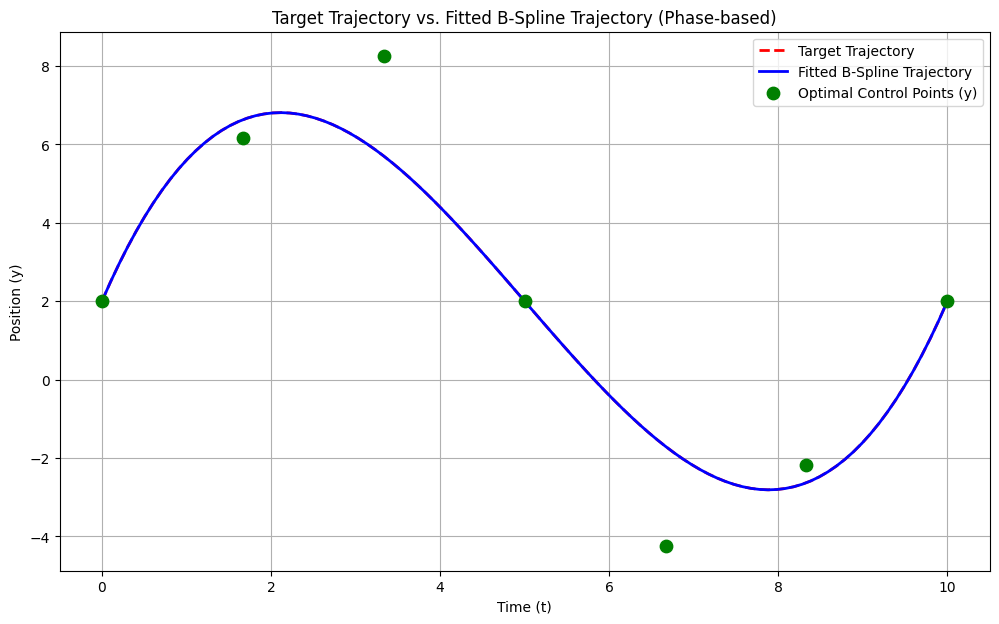

In [13]:
# 使用最优控制点创建最终的B样条
optimal_tck = (knots, optimal_control_points_y, p)
optimal_spline_y = BSpline(*optimal_tck)

# --- 第四步：可视化拟合结果 ---
plt.figure(figsize=(12, 7))
plt.plot(t_values, y_target, label='Target Trajectory', color='red', linestyle='--', linewidth=2)
plt.plot(t_values, optimal_spline_y(phi_values), label='Fitted B-Spline Trajectory', color='blue', linewidth=2) # <-- 评估时传入phi_values

# 绘制最优控制点，它们的x坐标同样需要从相位映射回时间
plt.scatter(control_points_t_x, optimal_control_points_y, color='green', marker='o', s=80, zorder=5, label='Optimal Control Points (y)')
# 为了更好的可视化，可以画出控制点在相位空间的x轴位置（但实际是y值）
# control_points_t_x 用于在时间轴上表示控制点的位置

plt.title('Target Trajectory vs. Fitted B-Spline Trajectory (Phase-based)')
plt.xlabel('Time (t)')
plt.ylabel('Position (y)')
plt.grid(True)
plt.legend()
plt.show()

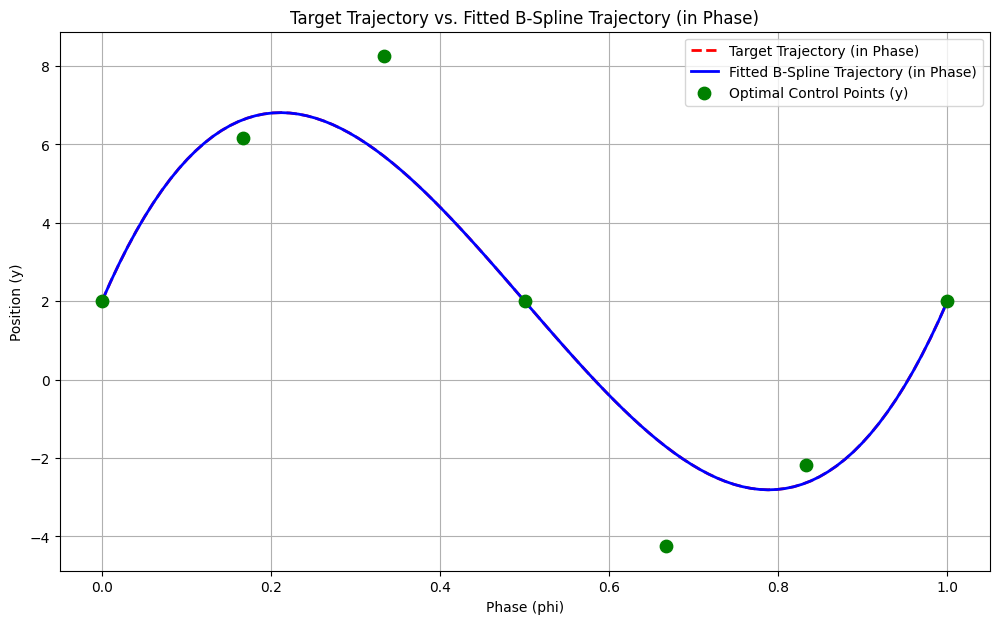

In [8]:
# 额外可视化：在相位空间中查看B样条和控制点
plt.figure(figsize=(12, 7))
plt.plot(phi_values, y_target, label='Target Trajectory (in Phase)', color='red', linestyle='--', linewidth=2)
plt.plot(phi_values, optimal_spline_y(phi_values), label='Fitted B-Spline Trajectory (in Phase)', color='blue', linewidth=2)

# 绘制最优控制点在相位空间的x轴位置
plt.scatter(control_points_phi_x, optimal_control_points_y, color='green', marker='o', s=80, zorder=5, label='Optimal Control Points (y)')

plt.title('Target Trajectory vs. Fitted B-Spline Trajectory (in Phase)')
plt.xlabel('Phase (phi)')
plt.ylabel('Position (y)')
plt.grid(True)
plt.legend()
plt.show()